In [1]:
import os 
import re

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import sklearn.model_selection
import sklearn.tree

In the previous notebook, we did the data cleaning on the board game data downloaded from BoardGameGeek website. In this notebook, we will try to model the data to see if we could use it to predict if a game is owned by many people.

# Read data in and explore the basic information

In [2]:
games = pd.read_csv('./data/games_detail_cleaned.csv')

In [3]:
games.shape

(44564, 155)

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44564 entries, 0 to 44563
Columns: 155 entries, id to Zombies
dtypes: float64(10), int64(143), object(2)
memory usage: 52.7+ MB


In [5]:
games.describe()

,id,n_names,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,...,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
count,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,...,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000
mean,79238.000942,1.554753,2001.083206,2.055269,5.926932,68.359034,60.998743,68.359034,7.895838,196.204313,...,0.016022,0.015999,0.049659,0.008707,0.002670,0.149560,0.028184,0.008527,0.044363,0.008639
std,68164.220203,4.437296,15.888733,0.727093,73.117442,446.678216,429.529777,446.678216,4.491565,1382.883221,...,0.125561,0.125474,0.217242,0.092903,0.051607,0.356644,0.165501,0.091949,0.205903,0.092546
min,1.000000,1.000000,1901.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18187.750000,1.000000,1994.000000,2.000000,3.000000,20.000000,20.000000,20.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49702.500000,1.000000,2006.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,143767.500000,1.000000,2012.000000,2.000000,6.000000,60.000000,60.000000,60.000000,12.000000,31.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,218270.000000,764.000000,2017.000000,10.000000,11299.000000,60120.000000,60120.000000,60120.000000,90.000000,64926.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Get some ideas about the target variable
Before we dive into any model, we need to get some idea of the target variable such as its distribution.

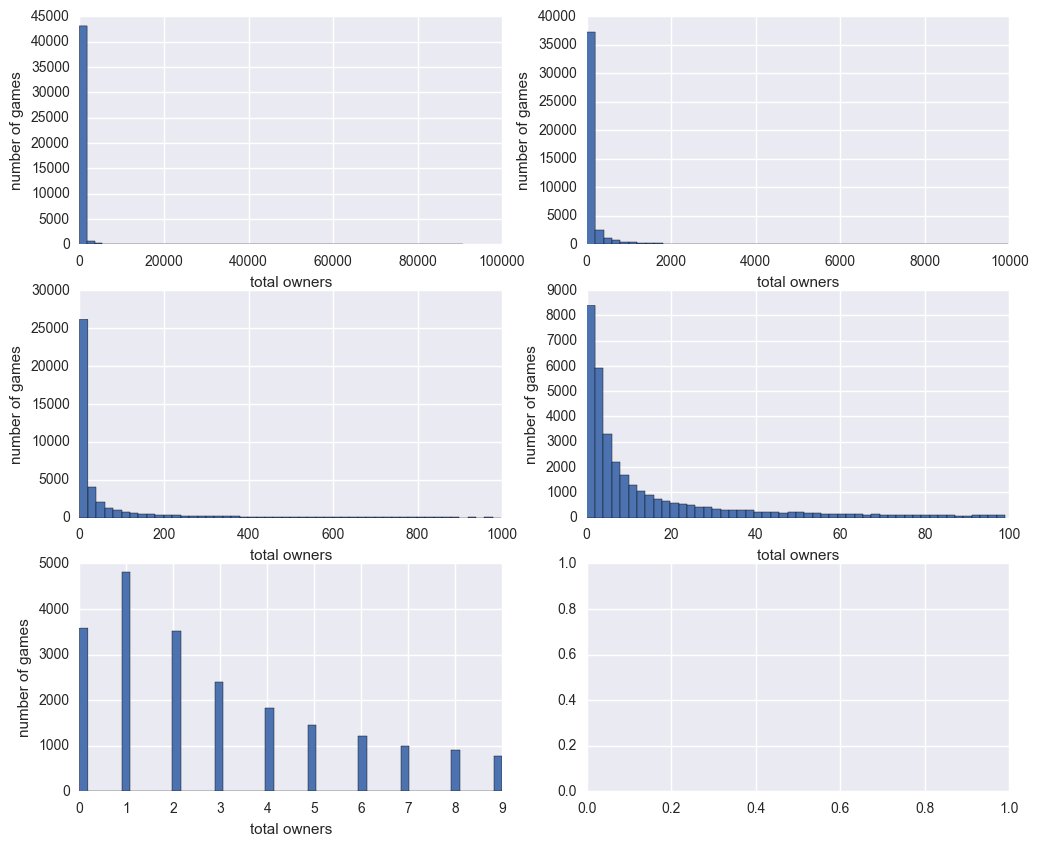

In [6]:
total_owners = games['total_owners']
fig, axs = plt.subplots(3, 2, figsize=(12,10))
axs = axs.reshape(1, -1)[0]
for i in range(5):
    ax = axs[i]
    ax.hist(total_owners[total_owners < 10 ** (5-i)], bins=50)
    ax.set_xlabel('total owners')
    ax.set_ylabel('number of games')

As expect, most of games have less owners and only a few games are very popular.

In [7]:
print('avg of total owners:', total_owners.mean())
print('median of total owners:', total_owners.median())

avg of total owners: 308.94919666098195
median of total owners: 11.0


It is probably not that easy to predict the exact number of total owners, so instead, we predict if a game would be popular, i.e. if the number of its owner is larger than the average number of owners.

In [8]:
games['popular'] = (games['total_owners'] > games['total_owners'].mean()).astype(int)

In [9]:
print('positive ratio: {:.2f}%'.format(games['popular'].sum() / games.shape[0] * 100))

positive ratio: 12.65%


# Determine the performance measure
Accuracy is not a good measure in our case since the labels are highly imbalanced (about 13% of data are labeled postive). A dummy model that label all sample point negative will have a accuracy 87% which is meaningless for perfomance measurement.<br>
In a imaginary businuess case we want to identify the boardgame which would be popular and avoid publishing games which would not, as our measures we choose area under the curve of reciever operating charachteristic curve (AUC of ROC) which is draw from true positive rate (TPR) and false postive rate (FPR). Our goal is to find if we can find a good model to maximize auc.

In [10]:
my_scorer = sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score, needs_proba=False, needs_threshold=False)

In [11]:
games.loc[:, games.columns[0:21]].dtypes

id                        int64
name                     object
n_names                   int64
yearpublished           float64
description              object
minplayers              float64
maxplayers              float64
playingtime             float64
minplaytime             float64
maxplaytime             float64
minage                  float64
users_rated               int64
average_rating          float64
bayes_average_rating    float64
total_owners              int64
total_traders             int64
total_wanters             int64
total_wishers             int64
total_comments            int64
total_weights             int64
average_weight          float64
dtype: object

In [12]:
# determine the features to draw correlation matrix
features = list(games.columns[0:21])
features.remove('id')
features.remove('name')
features.remove('description')

In [13]:
def corr_plot(corr):
#     # Generate a mask for the upper triangle
#     mask = np.zeros_like(corr, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1,
                square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

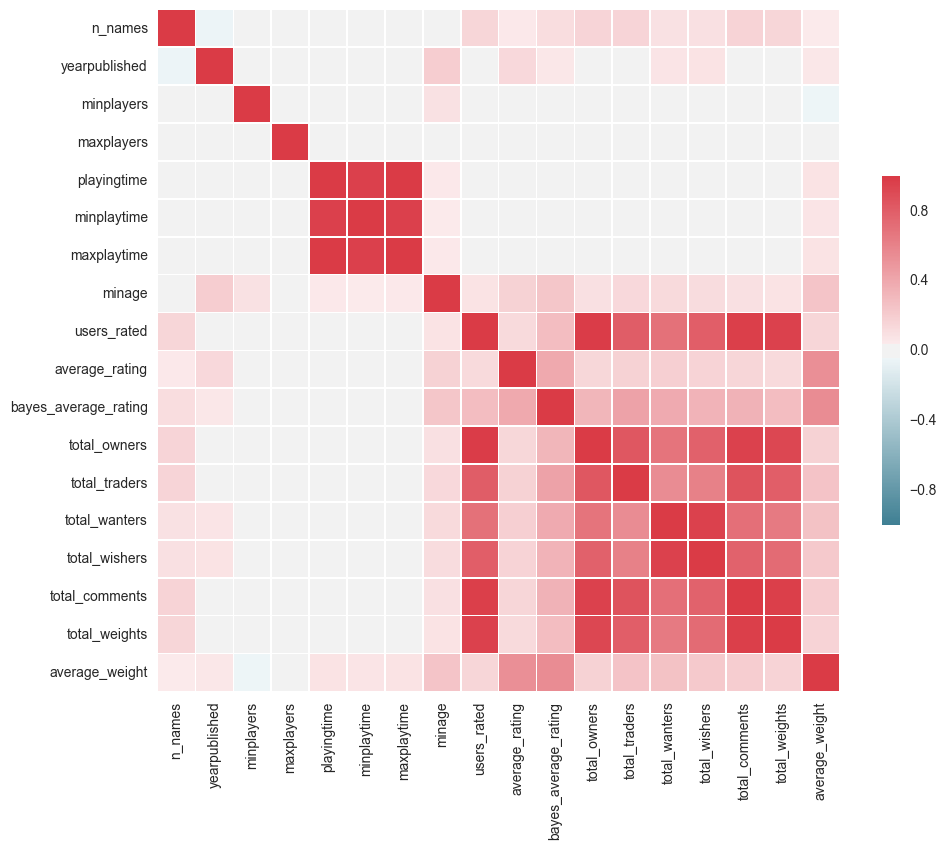

In [14]:
corr_matrix = games[features].corr()

corr_plot(corr_matrix)

In [15]:
abs(corr_matrix['total_owners']).sort_values(ascending=False)

total_owners            1.000000
users_rated             0.985930
total_comments          0.957530
total_weights           0.927475
total_traders           0.836408
total_wishers           0.786393
total_wanters           0.681255
bayes_average_rating    0.321410
average_weight          0.177862
n_names                 0.163764
average_rating          0.143385
minage                  0.094799
yearpublished           0.030341
maxplaytime             0.007394
playingtime             0.007394
minplaytime             0.004397
maxplayers              0.001325
minplayers              0.001301
Name: total_owners, dtype: float64

At least two things we can see from the correlation plot:
<ul>
    <li>`minplaytime`, `maxplaytime` and `playingtime` are highly correlated.</li>
    <li>Many features obtained from users are correlated with `total_owners`, such as `total_traders`, `users_rated`</li>
</ul>
In principal component analysis (PCA), highly correlated features can be compressed into fewer number of features via linear transformation, which helps to reduce the dimensions. However, if the a feature is highly correlated with the target variable, we need to be aware if it is another representation of target variable and which may not accesible or causes overfitting when facing unlabeled data.<br>
In our case variables as `total_comments` clearly depend on `total_owners` since more people have a game then more people comment on this game. So we have to filter out this type of variables.<br>

We will alos strike out variables `n_names`, `average_rating` and `bayes_average_rating`. Feature `n_names` might depend on `total_owners` since more popular a game is, more international versions a game has. As rating feature, it is clear that a game with higher rate has more owners (as this information is useless when a new game released), and `average_rating` does not consider the number of votes to give a correct statistical meaning.

Feature `average_weight` will be keep as an indicator of difficultiness of games.

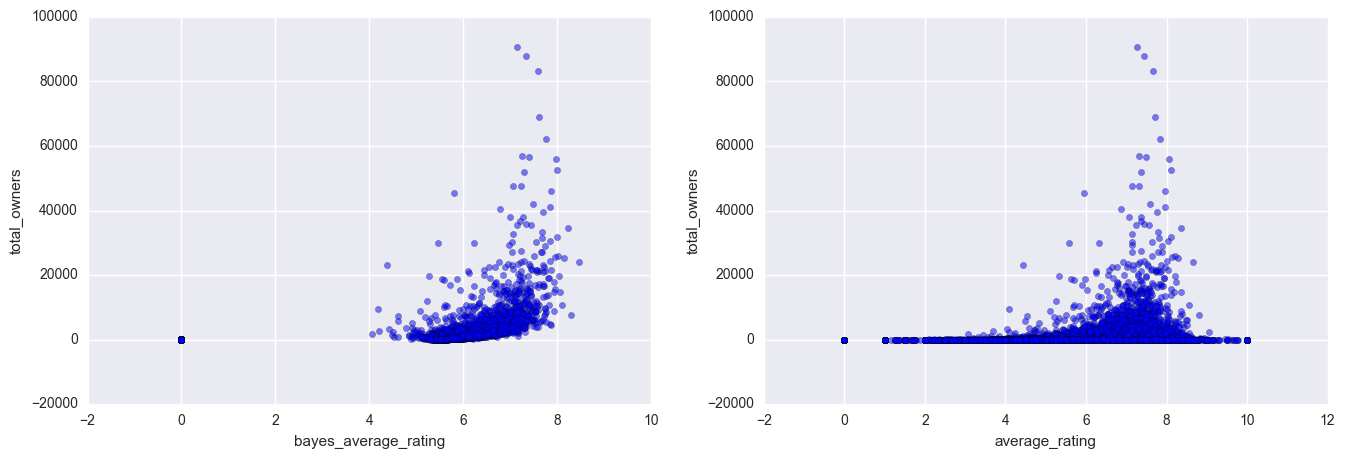

In [16]:
# The relation between rating features and total_owners
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].scatter(games['bayes_average_rating'], games['total_owners'], alpha=0.5)
axs[1].scatter(games['average_rating'], games['total_owners'], alpha= 0.5)

axs[0].set_xlabel('bayes_average_rating')
axs[1].set_xlabel('average_rating')

axs[0].set_ylabel('total_owners')
axs[1].set_ylabel('total_owners')

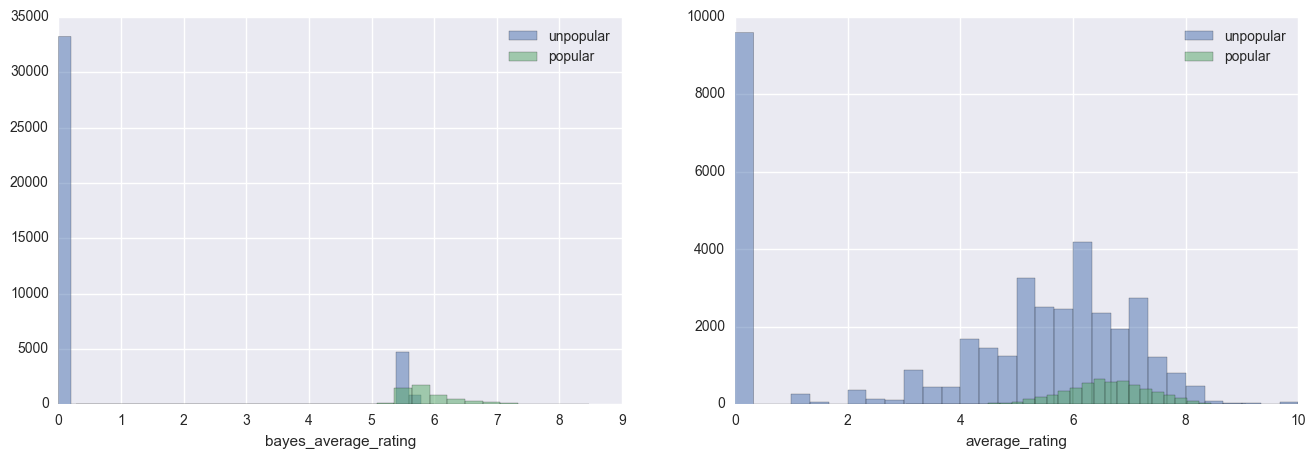

In [17]:
# relation after dechotomization
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(games[games['popular']==0]['bayes_average_rating'], bins=30, alpha=0.5, label='unpopular')
axs[0].hist(games[games['popular']==1]['bayes_average_rating'], bins=30, alpha=0.5, label='popular')

axs[1].hist(games[games['popular']==0]['average_rating'], bins=30, alpha=0.5, label='unpopular')
axs[1].hist(games[games['popular']==1]['average_rating'], bins=30, alpha=0.5, label='popular')

axs[0].set_xlabel('bayes_average_rating')
axs[1].set_xlabel('average_rating')

axs[0].legend()
axs[1].legend()


# Compress features

In [18]:
corr_matrix.loc[['playingtime', 'minplaytime', 'maxplaytime'], ['playingtime', 'minplaytime', 'maxplaytime']]

,playingtime,minplaytime,maxplaytime
playingtime,1.000000,0.967892,1.000000
minplaytime,0.967892,1.000000,0.967892
maxplaytime,1.000000,0.967892,1.000000


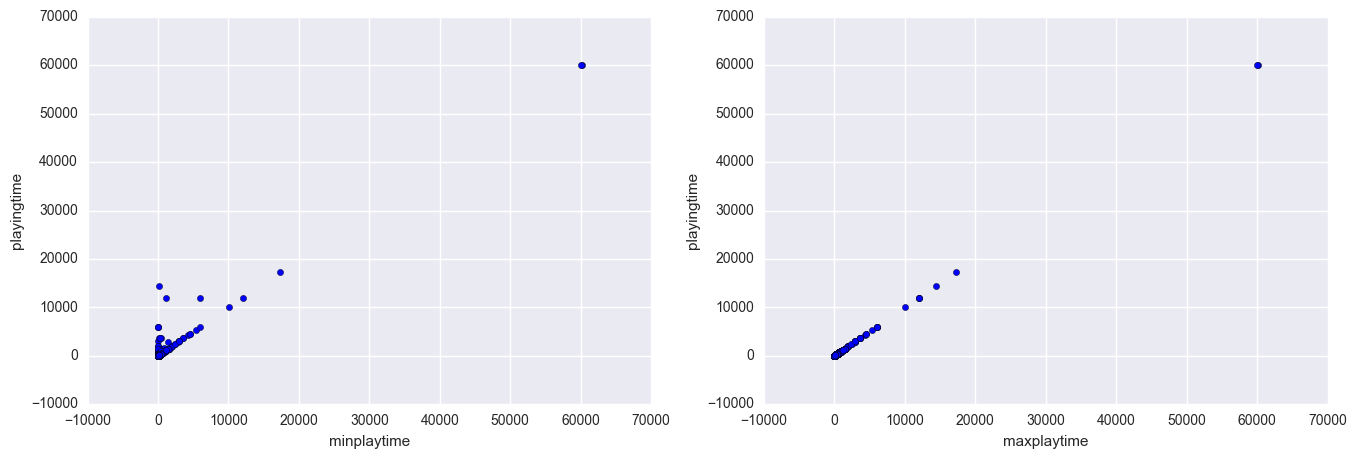

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].scatter(games['minplaytime'], games['playingtime'])
axs[1].scatter(games['maxplaytime'], games['playingtime'])

axs[0].set_xlabel('minplaytime')
axs[1].set_xlabel('maxplaytime')

axs[0].set_ylabel('playingtime')
axs[1].set_ylabel('playingtime')

Finding the principal component is equivalent to diagonalize the covariance matrix, which find a new coordinate where no covariance between new axes (variables). Since in the case of game play time, all three variables have the same scale and unit, so we don't do the standardization before the diagonalization.

In [20]:
time_cov_mat = games[['playingtime', 'minplaytime', 'maxplaytime']].cov()

In [21]:
eigvals, eigvecs = np.linalg.eig(time_cov_mat)

In [22]:
eigvals

array([  5.75455017e+05,  -1.48080734e-11,   8.08366971e+03])

In [23]:
eigvecs

array([[ -5.86971499e-01,  -7.07106781e-01,   3.94289816e-01],
       [ -5.57610006e-01,   5.90313938e-16,  -8.30103055e-01],
       [ -5.86971499e-01,   7.07106781e-01,   3.94289816e-01]])

In [24]:
print('compress ratio: {:2.3f}%'.format(eigvals[0] / eigvals.sum()* 100)) 

compress ratio: 98.615%


In [25]:
games['pc_time'] = ((games[['playingtime', 'minplaytime', 'maxplaytime']].values).dot(-eigvecs[:, 0])).copy()

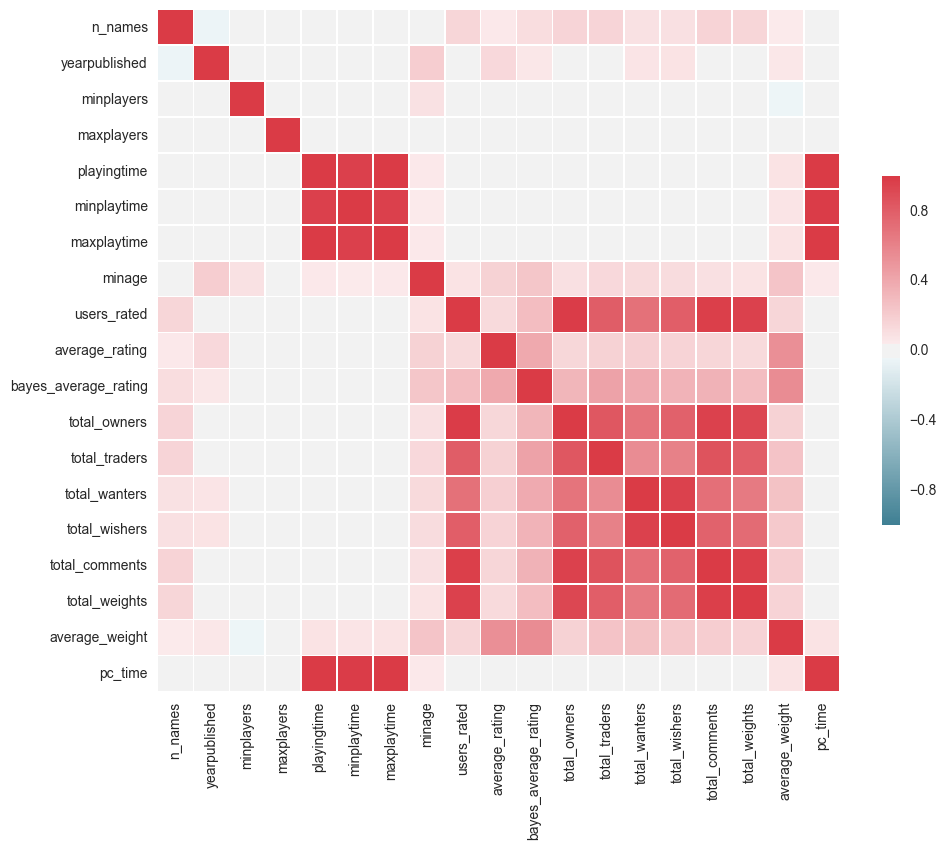

In [26]:
corr_matrix = games[features + ['pc_time']].corr()
corr_plot(corr_matrix)

Now we just strike out the features we don't to use to create the feature matrix `X`.

In [27]:
features = list(games.columns)
unwanted = ['id', 'name', 'n_names', 'description', 'yearpublished', 'minplaytime', 'maxplaytime', 'playingtime', 'users_rated', 'total_owners', 'total_traders',
       'total_wanters', 'total_wishers', 'total_comments', 'total_weights', 'average_rating', 'bayes_average_rating', 'popular']
features = [feature for feature in features if feature not in unwanted]

We separate the data into education set and evaluation set. The education set is using for training and selecting models, and the evaluation set is for the final performance evaluation. The education data is stratified sampled with the assumption that popular games are always about 13% of the total games. The evaluation set is 1/4 of the whole data set which contains around 10000 sample points to guarantee its validity.

In [28]:
features

['minplayers',
 'maxplayers',
 'minage',
 'average_weight',
 'Acting',
 'Action / Movement Programming',
 'Action Point Allowance System',
 'Area Control / Area Influence',
 'Area Enclosure',
 'Area Movement',
 'Area-Impulse',
 'Auction/Bidding',
 'Betting/Wagering',
 'Campaign / Battle Card Driven',
 'Card Drafting',
 'Chit-Pull System',
 'Co-operative Play',
 'Commodity Speculation',
 'Crayon Rail System',
 'Deck / Pool Building',
 'Dice Rolling',
 'Grid Movement',
 'Hand Management',
 'Hex-and-Counter',
 'Line Drawing',
 'Memory',
 'Modular Board',
 'Paper-and-Pencil',
 'Partnerships',
 'Pattern Building',
 'Pattern Recognition',
 'Pick-up and Deliver',
 'Player Elimination',
 'Point to Point Movement',
 'Press Your Luck',
 'Rock-Paper-Scissors',
 'Role Playing',
 'Roll / Spin and Move',
 'Route/Network Building',
 'Secret Unit Deployment',
 'Set Collection',
 'Simulation',
 'Simultaneous Action Selection',
 'Singing',
 'Stock Holding',
 'Storytelling',
 'Take That',
 'Tile Placemen

In [29]:
X = games[features].copy()
y = games['popular'].copy()

X_educ, X_eval, y_educ, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=1/4, random_state=36, stratify=y)

Since most of independent variables in our dataset are categorical variables and the target variable has been transformed into classification, models like regression or cluster methods might not be suitable without putting more effort. As we might want to see if we can came out a simple and explanable model, our first choice would be decision tree model. Ensemble models such as random forest or powerful model as neural network could be use later for getting better predictive power with less explainability as a tradeoff.

In [30]:
tree = sklearn.tree.DecisionTreeClassifier()

Here we use GridSearchCV to find a good hyperparameter setting

In [31]:
param_grid = {'max_depth': [10, 30, 50, 70], 
              'min_samples_split': [2, 10, 100, 1000], 
              'min_samples_leaf': [2, 10, 100, 1000], 
              'min_impurity_split': [0.1, 0.01, 0.001, 0.0001], 
              'random_state': [952]}

In [32]:
clf = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, scoring=my_scorer, n_jobs=4, cv=3)

In [33]:
clf.fit(X_educ, y_educ)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'random_state': [952], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001], 'min_samples_split': [2, 10, 100, 1000], 'min_samples_leaf': [2, 10, 100, 1000], 'max_depth': [10, 30, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [34]:
cv_results = pd.DataFrame(clf.cv_results_)
print(cv_results.loc[clf.best_index_, 'params'])
print(cv_results.loc[clf.best_index_, ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']])

{'random_state': 952, 'min_impurity_split': 0.0001, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_depth': 30}
mean_test_score       0.797824
mean_train_score      0.836439
std_test_score       0.0132804
std_train_score     0.00955361
Name: 114, dtype: object


In [35]:
clf.score(X_eval, y_eval)

0.80882330433337624

In [36]:
y_eval_pred = clf.predict(X_eval)
print(sklearn.metrics.classification_report(y_eval, y_eval_pred))

             precision    recall  f1-score   support

          0       0.95      0.96      0.95      9731
          1       0.70      0.66      0.68      1410

avg / total       0.92      0.92      0.92     11141



The model works not bad in identifing popular game. About 66% of popular game are predicted correctly. We would like to see deeper on how our model predict. Lets see the actual tree depth and feature importance.

In [37]:
clf.best_estimator_.tree_.max_depth

30

In [38]:
importances = pd.Series(data=clf.best_estimator_.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10)

average_weight                   0.797360
minage                           0.048968
Print & Play                     0.023717
Wargame                          0.020684
pc_time                          0.019717
Hand Management                  0.006141
maxplayers                       0.006018
Campaign / Battle Card Driven    0.003166
Variable Player Powers           0.003026
Area Control / Area Influence    0.002911
dtype: float64

In [39]:
sklearn.tree.export_graphviz(clf.best_estimator_, out_file='./models/tree_00.dot', feature_names=features)

The model highly depends on feature `average_weight` which might depend on `total_owners` since this feature unlike features we use, is from user voting system. We test it by making it the only feature for model building. If it depends on `total_owners`, this test will give a similar performance.

In [40]:
clf.fit(X_educ['average_weight'].reshape(-1,1), y_educ)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'random_state': [952], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001], 'min_samples_split': [2, 10, 100, 1000], 'min_samples_leaf': [2, 10, 100, 1000], 'max_depth': [10, 30, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [41]:
cv_results = pd.DataFrame(clf.cv_results_)
print(cv_results.loc[clf.best_index_, 'params'])
print(cv_results.loc[clf.best_index_, ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']])

{'min_samples_split': 100, 'max_depth': 30, 'random_state': 952, 'min_samples_leaf': 10, 'min_impurity_split': 0.1}
mean_test_score       0.840901
mean_train_score       0.85599
std_test_score      0.00310591
std_train_score     0.00501673
Name: 70, dtype: object


In [42]:
clf.score(X_eval['average_weight'].reshape(-1, 1), y_eval)

0.8554465475911962

In [43]:
clf.best_estimator_.tree_.max_depth

17

In [44]:
sklearn.tree.export_graphviz(clf.best_estimator_, out_file='./models/tree_01.dot', feature_names=['average_weight'])

It turns out that solely a `avererage_weight` gives even a better performace. 

The result shows that `average_weight` does have the ability to predict game popularity. And test result proves the concern that `average_weight` depends on `total_owners`. Following figure shows how this information is hidden in it.

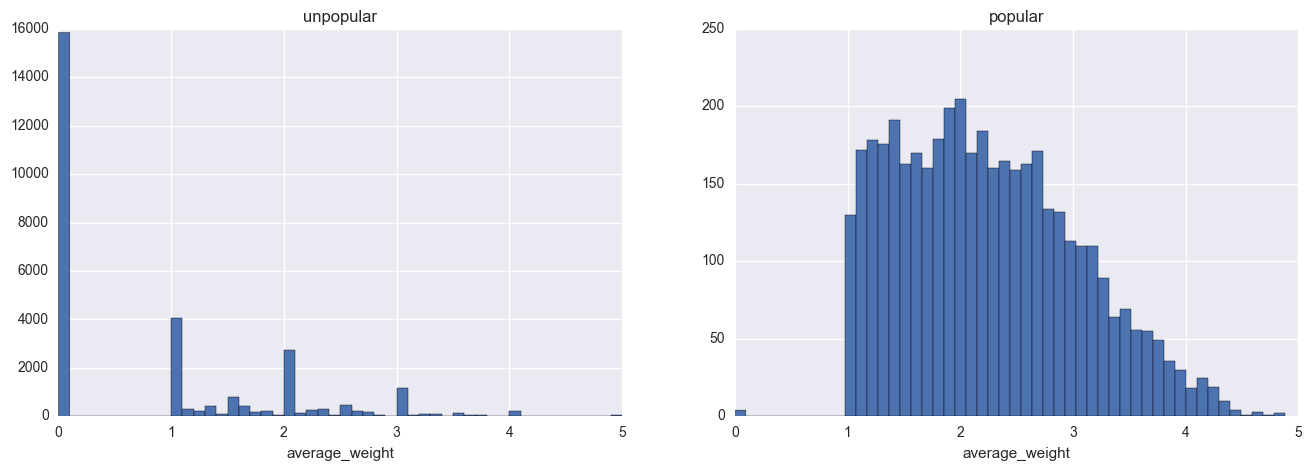

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].hist(X_educ.loc[y_educ==0, 'average_weight'], bins=50)
axs[0].set_xlabel('average_weight')
axs[0].set_title('unpopular')

axs[1].hist(X_educ.loc[y_educ==1, 'average_weight'], bins=50)
axs[1].set_xlabel('average_weight')
axs[1].set_title('popular')

The plots show that the average weight of unpopular games tend to accumulate around integers and half integers. The reason is following: the average weight is given by the average over the votes from users. The choices that users have are integers from 0 to 5, so when a game is voted by a few users, e.g. one or two, the average of that vote would be an integer or half integer. On the other hand, popular games have more owners so as voters. Their average weights will be spread out more evenly compared to unpopular games. That is how `average_weight` reveals the information of popularity.<br>

Now we want to see how worse it would be if we remove `average_weight` from feature list.

In [46]:
features.remove('average_weight')

clf.fit(X_educ[features], y_educ)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'random_state': [952], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001], 'min_samples_split': [2, 10, 100, 1000], 'min_samples_leaf': [2, 10, 100, 1000], 'max_depth': [10, 30, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [47]:
cv_results = pd.DataFrame(clf.cv_results_)
print(cv_results.loc[clf.best_index_, 'params'])
print(cv_results.loc[clf.best_index_, ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']])

{'min_samples_split': 2, 'max_depth': 70, 'random_state': 952, 'min_samples_leaf': 2, 'min_impurity_split': 0.01}
mean_test_score       0.601844
mean_train_score      0.811881
std_test_score      0.00308655
std_train_score     0.00204799
Name: 208, dtype: object


In [48]:
clf.score(X_eval[features], y_eval)

0.58778047929006594

The performance is only slightly better than a dummy classifier (auc=0.5), and is more overfitting. This is expected as `average_weighting` dominated the feature importantce before.

In [49]:
clf.best_estimator_.max_depth

70

In [50]:
importances = pd.Series(data=clf.best_estimator_.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10)

pc_time                          0.132347
minage                           0.126681
maxplayers                       0.073404
minplayers                       0.033324
Dice Rolling                     0.020783
Hand Management                  0.018884
Print & Play                     0.018078
Card Game                        0.015031
Set Collection                   0.014545
Area Control / Area Influence    0.014408
dtype: float64

The tree grows to the depth limit and would be meaningless to display such a big tree (which is partly due to the number of categorical variables).

One way we could do is putting the `average_weight` back after we eliminate the information about the number of people vote. 
We round all the games' weight to their nearest integer or half integer.

In [51]:
def round_to_near_half(num):
    return round(num * 2)/2

In [52]:
games['average_weight_rounded'] = games['average_weight'].apply(round_to_near_half)

features = features + ['average_weight_rounded']

X = games[features].copy()
y = games['popular'].copy()

X_educ, X_eval, y_educ, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=1/4, random_state=36, stratify=y)

First we do a test to see if `average_weight_rounded` is still so powerful in predicting `total_owners`.

In [53]:
clf.fit(X_educ['average_weight_rounded'].reshape(-1, 1), y_educ)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'random_state': [952], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001], 'min_samples_split': [2, 10, 100, 1000], 'min_samples_leaf': [2, 10, 100, 1000], 'max_depth': [10, 30, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [54]:
cv_results = pd.DataFrame(clf.cv_results_)
print(cv_results.loc[clf.best_index_, 'params'])
print(cv_results.loc[clf.best_index_, ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']])

{'random_state': 952, 'min_impurity_split': 0.1, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
mean_test_score     0.5
mean_train_score    0.5
std_test_score        0
std_train_score       0
Name: 0, dtype: object


As we can see here, after we round all the weights, the performance of using `average_weight_rounded` only is as using dummy classifier.

In [55]:
clf.fit(X_educ, y_educ)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'random_state': [952], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001], 'min_samples_split': [2, 10, 100, 1000], 'min_samples_leaf': [2, 10, 100, 1000], 'max_depth': [10, 30, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=0)

In [56]:
cv_results = pd.DataFrame(clf.cv_results_)
print(cv_results.loc[clf.best_index_, 'params'])
print(cv_results.loc[clf.best_index_, ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']])

{'random_state': 952, 'min_impurity_split': 0.001, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30}
mean_test_score       0.661982
mean_train_score      0.821776
std_test_score      0.00987004
std_train_score      0.0090919
Name: 97, dtype: object


In [57]:
clf.score(X_eval, y_eval)

0.660689716494263

Adding `average_weight_rounded` back to features makes the performance increases 8%.

In [58]:
y_eval_pred = clf.predict(X_eval)
print(sklearn.metrics.classification_report(y_eval, y_eval_pred))

             precision    recall  f1-score   support

          0       0.91      0.95      0.93      9731
          1       0.52      0.37      0.43      1410

avg / total       0.86      0.88      0.87     11141



In [59]:
clf.best_estimator_.tree_.max_depth

30

In [67]:
sklearn.tree.export_graphviz(clf.best_estimator_, './models/tree_02.dot', max_depth=10, feature_names=features)

In [60]:
importances = pd.Series(data=clf.best_estimator_.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10)

average_weight_rounded           0.313212
minage                           0.096587
pc_time                          0.078914
maxplayers                       0.050116
Print & Play                     0.021221
Hand Management                  0.019400
minplayers                       0.012873
Variable Player Powers           0.012342
Dice Rolling                     0.012155
Area Control / Area Influence    0.011640
dtype: float64

The result shows that if we remove the variables and information depending on `tota_owners`, our simple decision tree model can only have 37% TPR with 66% auc of roc. In a single tree model, it shows the most important factor is still how difficult (complicated) a game is to play or to understand. Followed up are age, playtime, limit of player number. The most important category is `Print & Play`. It is clearly beacause most of `Print & Play` games are free, and price is something we didn't consider here.
To get a model with better performance, followings are possible methods:
<ul>
    <li>Oversample or undersample the imbalance data</li>
    <li>Apply correspondence analysis to transform features into better shapes for decision tree</li>
    <li>Get more features such as applying bag of word on descriptions and names.</li>
    <li>Get the price of each game online</li>
    <li>Try other algorithms such as random forest or neural network</li>
</ul>

Before we move on to next notebook, it would be nice to address a problem of decision tree. Consider a situation that data with two independent features are linear separated by the linear combination of two features, e.g. top right and bottom left triangles in a rectangle. Since the bifurcation of tree is a boudnary perpendicular to feature axis, it would be very inefficient in describing a diagonal line. As data is larger, the tree needs more bifurcation to approach the boundary. Thus another way to make our current model better is to do some feature engineer and find a proper feature basis.

In [2]:
os.system('jupyter nbconvert --to html 01_modelling.ipynb')

0